<h1 align = 'center'>Trabalho de Circuitos Elétricos II<h1/>

<p align = 'center'>
    <img src = '../docs/logo.jpeg'/>
<p/>

Este projeto tem como objetivo o estudo referente ao dimensionamento de um Banco de Capacitores.

Desenvolvedores:

- André Vitor Cadena de Oliveira
- Fábio Augusto Almeida Marçal
- Gabriel Nazário Gonçalves
- Lorenzo Carrera de Oliveira
- Mateus Pincho de Oliveira

---

In [1]:
# Importando os módulos utilizados...
import numpy as np
import pandas as pd
import plotly.graph_objects as go

df = pd.read_csv('curvas_de_carga_da_industria.csv') # Constrói um dataframe pandas com os dados fornecidos
df.index = np.full(24, '') # Esconde a indexação do dataframe

## Questão 1

Uma industria de médio porte identificou multas na fatura de energia elétrica 1 mês após instalar um gerador distribuído fotovoltaico para reduzir os custos. Um engenheiro eletricista, contratado  pela industria, realizou a medição de potência na saída do gerador fotovoltaico, utilizando um analisador de energia Fluke 435. 

As curvas de potência ativa e reativa da indústria antes da instalação do gerador e a curva de potência injetada pelo gerador, discretizadas em períodos de 1 em 1 hora, estão apresentadas em `curvas_de_carga_da_industria.csv`. A partir dessas curvas, projete um **Quadro para Correção do Fator de Potência** , utilizando um controlador de carga capaz de realizar a inserção de 6 células capacitivas em paralelo. 

Para o dimensionamento, considere como fator de potência mínimo o valor mencionado no Modulo 7 do PRODIST/ANEEL. 

**OBS:** fator de potência mínimo exigido = $0,92$.

--- 

## Produção da Indústria

Primeiramente, avalia-se quanto de potência ativa a indústria de fato está consumindo. Como ela tem a sua disposição um gerador distribuído fotovoltaico, haverá um abatimento na potência total consumida, de modo que:

$$P_{total} = P_{consumida} - P_{gerador}$$

---

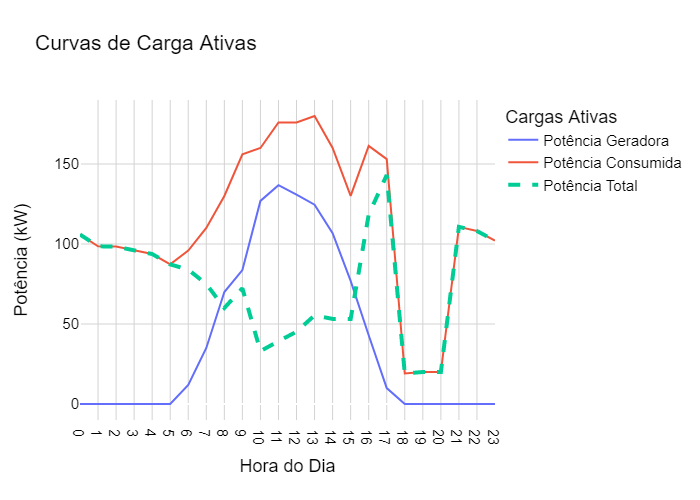

In [2]:
# Plotando as Curvas de Cargas Ativas

fig = go.Figure()

# Parâmetros do Gráfico
fig.update_layout(
    title='Curvas de Carga Ativas',
    xaxis_title='Hora do Dia',
    yaxis_title='Potência (kW)',
    legend_title='Cargas Ativas',
    plot_bgcolor='white',
    font=dict(
        family='Arial',
        size=15,
        color='black'
    ),
    xaxis=dict(
        gridcolor='lightgray',
        tickmode = 'linear',
        dtick = 1,
        range=[0,23]
    ),
    yaxis=dict(
        gridcolor='lightgray'
    )
)

# Calculando Potência Total
df['Potência Total'] = df['Potência Consumida'] - df['Potência Geradora']

for P in df.columns[1:4]:
    l = dict()
    if P == 'Potência Total':
        l = dict(
            width=4,
            dash='dash'
        )

    fig.add_trace(go.Scatter(
        x=df['Hora'],
        y=df[P],
        name=P,
        line=l
    )
)

fig.show(renderer='png')


## Cálculo do Fator de Potência 

O cálculo do fator de potência para cada hora do dia será dado por:

$${FP} = \cos(\arctan(\frac{Q}{P_{total}}))$$

Para cada horário, deve-se verificar se há a necessidade de corrigir o fator de potência.
   - Se ${FP} > {FP}_{min}$, sendo ${FP}_{min} = 0,94$, não há necessidade de corrigir o fator de potência;
   - Porém, se ${FP} < {FP}_{min}$, deve-se corrigir o fator de potência.

**OBS:** o fator de potência mínimo exigido é de $0,92$. Porém, para uma margem de erro mais segura, será utilizado $0,94$.

---

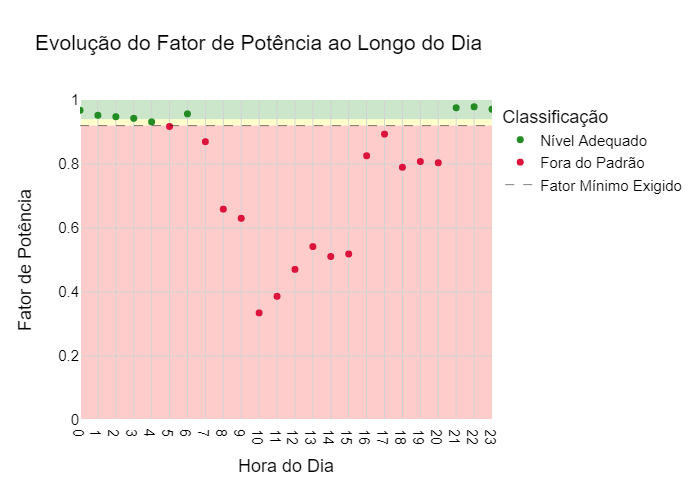

In [3]:
# Plotando as Curvas de Cargas Ativas

fig = go.Figure()

# Parâmetros do Gráfico
fig.update_layout(
    title='Evolução do Fator de Potência ao Longo do Dia',
    xaxis_title='Hora do Dia',
    yaxis_title='Fator de Potência',
    legend_title='Classificação',
    plot_bgcolor='white',
    font=dict(
        family='Arial',
        size=15,
        color='black'
    ),
    xaxis=dict(
        gridcolor='lightgray',
        tickmode = 'linear',
        dtick = 1,
        range=[0,23]
    ),
    yaxis=dict(
        gridcolor='lightgray',
        range=[0,1]
    )
)

# Calculando a evolução do Fator de Potência 
df['FP'] = (df['Reativo Consumido']/df['Potência Total']).apply(np.arctan).apply(np.cos)

fig.add_hrect(
    y0=0.94, 
    y1=1.00, 
    line_width=0, 
    fillcolor='green', 
    opacity=0.2,
    layer='below')

fig.add_hrect(
    y0=0.92, 
    y1=0.94, 
    line_width=0, 
    fillcolor='yellow', 
    opacity=0.2,
    layer='below')

fig.add_hrect(
    y0=0.00, 
    y1=0.92, 
    line_width=0, 
    fillcolor='red', 
    opacity=0.2,
    layer='below')

fig.add_trace(go.Scatter(
    x=df['Hora'],
    y=df['FP'].apply(lambda x: x if x > 0.92 else None), # Somente os pontos que estão dentro da norma
    name='Nível Adequado',
    mode='markers',
    marker=dict(
            size=7,
            color='forestgreen'
        )
    )
)

fig.add_trace(go.Scatter(
    x=df['Hora'],
    y=df['FP'].apply(lambda x: x if x <= 0.92 else None), # Somente os pontos que estão fora do padrão
    name='Fora do Padrão',
    mode='markers',
    marker=dict(
            size=7,
            color='crimson'
        )
    )
)

fig.add_trace(go.Scatter(
    x=df['Hora'],
    y=np.full(24, 0.92),
    name='Fator Mínimo Exigido',
    line=dict(
            width=0.5,
            dash='dash',
            color='black'
        )
    )
)

fig.show(renderer='png')


## Controle do Fator de Potência 

Para o controle do Fator de Potência da indústria, será utilizado um banco de capacitores para corrigir o reativo produzido pela indústria e aumentar o fator de potência de modo que ${FP} \geq {FP}_{min} = 0,94$.

A quantidade de Potência Reativa Capacitiva necessária para **corrigir** o fator de potência é calculada por:


$$Q_{corr} = P\cdot [\tan(\arccos({FP}))-\tan(\arccos({FP}_{min}))]$$

Para atingir o $Q_{corr}$ esperado, é utilizada uma associação de células capacitivas disponíveis no banco do controlador.

Observando o gráfico do reativo capacitivo necessário e sabendo queo controlador disponível possui uma capacidade de $6$ células, foram escolhidos os seguintes capacitores:

- $Q_1 = 3,0$ kVAr
- $Q_2 = 7,5$ kVAr
- $Q_3 = 10,0$ kVAr
- $Q_4 = 17,5$ kVAr
- $Q_5 = 25,0$ kVAr
- $Q_6 = 35,0$ kVAr

A função `combcap` calcula o valor da associação de capacitores mais próxima de necessária para um dado momento do dia. 

---

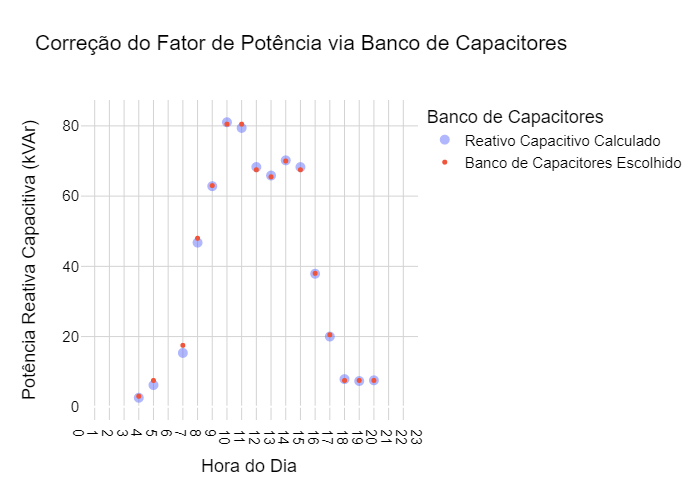

In [4]:
# Plotando as Curvas de Cargas Ativas

fig = go.Figure()

# Parâmetros do Gráfico
fig.update_layout(
    title='Correção do Fator de Potência via Banco de Capacitores',
    xaxis_title='Hora do Dia',
    yaxis_title='Potência Reativa Capacitiva (kVAr)',
    legend_title='Banco de Capacitores',
    plot_bgcolor='white',
    font=dict(
        family='Arial',
        size=15,
        color='black'
    ),
    xaxis=dict(
        gridcolor='lightgray',
        tickmode = 'linear',
        dtick = 1,
        range=[0,23]
    ),
    yaxis=dict(
        gridcolor='lightgray'
    )
)

# Calculando a quantidade necessária de potência reativa capacitiva
df['Reativo Capacitivo Calculado'] = df['Potência Total']*(df['FP'].apply(np.arccos).apply(np.tan)-np.tan(np.arccos(0.94)))

# Desconsiderando valores negativos (ou seja, quando não é necessária a correção)
df['Reativo Capacitivo Calculado'] = df['Reativo Capacitivo Calculado'].apply(lambda x: '-' if x <= 0 else x)

fig.add_trace(go.Scatter(
    x=df['Hora'],
    y=df['Reativo Capacitivo Calculado'],
    name='Reativo Capacitivo Calculado',
    mode='markers',
    marker=dict(
        size=10,
        opacity=0.5
        )
    )
)

# Potência reativa nominal dos capacitores escolhidos no catálogo em kVAr
Qc = [3, 7.5, 10, 17.5, 25, 35]

# Recebe a lista de capacitores e o valor desejado a se atingir com a combinação em paralelo deles
# Retorna o valor combinado mais próximo possível do desejado
def combcap(Qc, kVAr):
    n_celulas = len(Qc)
    possiveis_comb = [[Qc[k] for k in range(n_celulas) if i & 1 << k] for i in range(2**n_celulas)]
    possiveis_kVAr = np.array(list(map(sum, possiveis_comb))) 
    return possiveis_kVAr[np.absolute(possiveis_kVAr-kVAr).argmin()]

df['Banco de Capacitores Escolhido'] = df['Reativo Capacitivo Calculado'].apply(lambda x: '-' if x == '-' else combcap(Qc, x))

fig.add_trace(go.Scatter(
    x=df['Hora'],
    y=df['Banco de Capacitores Escolhido'],
    name='Banco de Capacitores Escolhido',
    mode='markers',
    marker=dict(
        size=5
        )
    )
)

fig.show(renderer='png')


## Desempenho do Controlador

O fator de potência corrigido será dado por:

$${FP}_{corr} = \cos(\arctan(\frac{Q-Q_{corr}}{P{total}}))$$

E espera-se que ele fique acima do fator mínimo ${FP}_{min}$ exigido de $0,92$.

---

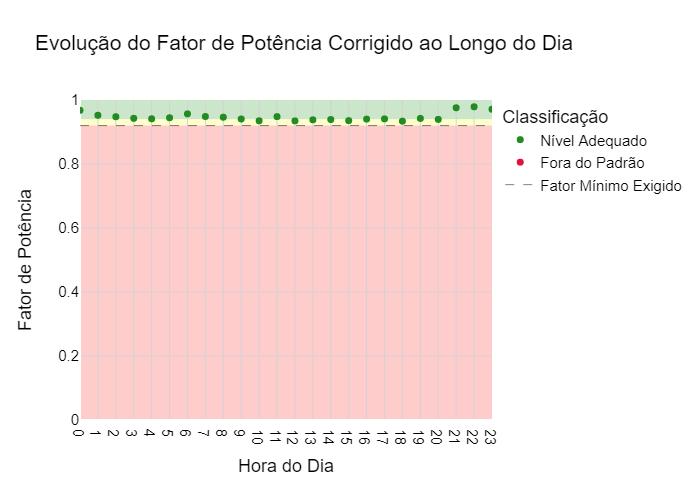

In [5]:
# Plotando as Curvas de Cargas Ativas

fig = go.Figure()

# Parâmetros do Gráfico
fig.update_layout(
    title='Evolução do Fator de Potência Corrigido ao Longo do Dia',
    xaxis_title='Hora do Dia',
    yaxis_title='Fator de Potência',
    legend_title='Classificação',
    plot_bgcolor='white',
    font=dict(
        family='Arial',
        size=15,
        color='black'
    ),
    xaxis=dict(
        gridcolor='lightgray',
        tickmode = 'linear',
        dtick = 1,
        range=[0,23]
    ),
    yaxis=dict(
        gridcolor='lightgray',
        range=[0,1]
    )
)

# Calculando a evolução do Fator de Potência 
df['FP Corrigido'] = ((df['Reativo Consumido']-df['Banco de Capacitores Escolhido'].apply(lambda x: 0 if x == '-' else x))/df['Potência Total']).apply(np.arctan).apply(np.cos)

fig.add_hrect(
    y0=0.94, 
    y1=1.00, 
    line_width=0, 
    fillcolor='green', 
    opacity=0.2,
    layer='below')

fig.add_hrect(
    y0=0.92, 
    y1=0.94, 
    line_width=0, 
    fillcolor='yellow', 
    opacity=0.2,
    layer='below')

fig.add_hrect(
    y0=0.00, 
    y1=0.92, 
    line_width=0, 
    fillcolor='red', 
    opacity=0.2,
    layer='below')

fig.add_trace(go.Scatter(
    x=df['Hora'],
    y=df['FP Corrigido'].apply(lambda x: x if x > 0.92 else None), # Somente os pontos que estão dentro da norma
    name='Nível Adequado',
    mode='markers',
    marker=dict(
            size=7,
            color='forestgreen'
        )
    )
)

fig.add_trace(go.Scatter(
    x=df['Hora'],
    y=df['FP Corrigido'].apply(lambda x: x if x <= 0.92 else None), # Somente os pontos que estão fora do padrão
    name='Fora do Padrão',
    mode='markers',
    marker=dict(
            size=7,
            color='crimson'
        )
    )
)

fig.add_trace(go.Scatter(
    x=df['Hora'],
    y=np.full(24, 0.92),
    name='Fator Mínimo Exigido',
    line=dict(
            width=0.5,
            dash='dash',
            color='black'
        )
    )
)

fig.show(renderer='png')


## Questão 02

Considerando o banco de capacitores especificado na questão anterior, apresente o orçamento detalhado dos materiais para compra e montagem de um banco de capacitores trifásico (380 V Fase-Fase), utilizando o controlador automático de fator de potência modelo PFW01-M06 da WEG. 

A lista de materiais deve apresentar: 
- Capacitores
- Controlador
- Disjuntores
- Contatores para Manobra de Capacitores
- Chaves
- Sinaleiros 
- Quadro de Comando

---

# Orçamento do Projeto

### Células Capacitivas

Carga capacitiva responsável pela correção do Fator de Potência.

|     | Unidades Capacitivas (kVAr) | Preços                                                                                                                                                                                                                   |
| --- | -------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| C1  | 3                    | [R$ 198,58](https://produto.mercadolivre.com.br/MLB-2627006956-capacitor-trifasico-weg-3kvar-380v-ucwt3v40l10hd-_JM#position=5&search_layout=stack&type=item&tracking_id=eb587902-7d6a-4429-80ae-f96dcc790606)           |
| C2  | 7,5                  | [R$ 318,26](https://produto.mercadolivre.com.br/MLB-2626263609-unidade-capacitiva-trifasica-weg-75kvar-380v-ucwt75v40n20h-_JM#position=8&search_layout=stack&type=item&tracking_id=465a4515-a84e-4aa3-8920-9109b5978217) |
| C3  | 10                   | [R$ 368,97](https://produto.mercadolivre.com.br/MLB-2095887451-unidade-capacitiva-trifasica-weg-ucwt10v40n20-10kvar-380v-_JM#position=3&search_layout=stack&type=item&tracking_id=465a4515-a84e-4aa3-8920-9109b5978217)  |
| C4  | 17,5                 | [R$ 764,96](https://produto.mercadolivre.com.br/MLB-2817749204-capacitor-correco-fator-potncia-175kvar-380v-trifasico-_JM#position=4&search_layout=stack&type=item&tracking_id=802421f3-4b13-4bf2-9872-845d90d7d5f4)     |
| C5  | 25                   | [R$ 763,80](https://produto.mercadolivre.com.br/MLB-2075245921-unidade-capacitiva-trifasica-25kvar-380v-_JM#position=7&search_layout=stack&type=item&tracking_id=7f4d83dd-8250-49c9-a1ea-70964b131d6e)                   |
| C6  | 35                   | [R$ 1.126,66](https://produto.mercadolivre.com.br/MLB-2075245921-unidade-capacitiva-trifasica-25kvar-380v-_JM#position=7&search_layout=stack&type=item&tracking_id=7f4d83dd-8250-49c9-a1ea-70964b131d6e)                 |


### Contatores

Dispositivo eletromecânico que permite a comutação de altas correntes.

|     | Contatores | Preços                                                                                                                                                                                                                                                                     |
| --- | ---------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| C1  | CWMC18     | [R$ 249,00](https://www.mercadolivre.com.br/contator-para-capacitor-8kvar-220v-15kvar-380v-tripolar/p/MLB26819836?pdp_filters=category:MLB270071#searchVariation=MLB26819836&position=1&search_layout=stack&type=product&tracking_id=09f327b6-3bab-4ec9-a04e-cb326703b143) |
| C2  | CWMC18     | [R$ 249,00](https://www.mercadolivre.com.br/contator-para-capacitor-8kvar-220v-15kvar-380v-tripolar/p/MLB26819836?pdp_filters=category:MLB270071#searchVariation=MLB26819836&position=1&search_layout=stack&type=product&tracking_id=09f327b6-3bab-4ec9-a04e-cb326703b143) |
| C3  | CWMC18,    | [R$ 249,00](https://www.mercadolivre.com.br/contator-para-capacitor-8kvar-220v-15kvar-380v-tripolar/p/MLB26819836?pdp_filters=category:MLB270071#searchVariation=MLB26819836&position=1&search_layout=stack&type=product&tracking_id=09f327b6-3bab-4ec9-a04e-cb326703b143) |
| C4  | CWMC25     | [R$ 262,24](https://produto.mercadolivre.com.br/MLB-2744792659-contator-para-capacitor-6kvar-220v-10kvar-380v-tripolar-_JM#position=15&search_layout=stack&type=item&tracking_id=5f1e7235-c410-416a-93d6-bdb68780559b)                                                     |
| C5  | CWMC32     | [R$ 355,63](https://produto.mercadolivre.com.br/MLB-3167454552-contator-tripolar-32a-380vca-cwm-weg-i-_JM#position=11&search_layout=stack&type=item&tracking_id=0fc366f6-d76f-418e-9d1f-77c522ee3a2a)                                                                      |
| C6  | CWMC50     | [R$ 727,60](https://produto.mercadolivre.com.br/MLB-2683928171-contator-para-capacitor-25kvar-220v-40kvar-380v-tripolar-_JM#position=3&search_layout=stack&type=item&tracking_id=1d7cebb7-cb4a-420f-8221-67cb8a157a0f)                                                     |

### Disjuntores

Dispositivo responsável por proteger a rede de correntes elétricas acima do nível esperado.

|     | Disjuntores                | Preços   |
| --- | -------------------------- | -------- |
| C1  | Soprano Curva C 10A        | [R$ 40,47](https://produto.mercadolivre.com.br/MLB-2732150356-disjuntor-tripolar-din-6a10a16a20a25a32a-1un-_JM?matt_tool=14372353&matt_word=&matt_source=google&matt_campaign_id=14302215552&matt_ad_group_id=150145935327&matt_match_type=&matt_network=g&matt_device=c&matt_creative=649558500191&matt_keyword=&matt_ad_position=&matt_ad_type=pla_with_promotion&matt_merchant_id=478847011&matt_product_id=MLB2732150356&matt_product_partition_id=2016650229967&matt_target_id=aud-1966981570049:pla-2016650229967&gclid=Cj0KCQjwy4KqBhD0ARIsAEbCt6h4OBfd-Vt67CxcuNBz6A9QbNa4z9Ktr1ig-yYCgb6kFznOWW-4Fz4aAobbEALw_wcB) |
| C2  | Soprano Curva C 16A        | [R$ 40,47](https://produto.mercadolivre.com.br/MLB-2732150356-disjuntor-tripolar-din-6a10a16a20a25a32a-1un-_JM?matt_tool=14372353&matt_word=&matt_source=google&matt_campaign_id=14302215552&matt_ad_group_id=150145935327&matt_match_type=&matt_network=g&matt_device=c&matt_creative=649558500191&matt_keyword=&matt_ad_position=&matt_ad_type=pla_with_promotion&matt_merchant_id=478847011&matt_product_id=MLB2732150356&matt_product_partition_id=2016650229967&matt_target_id=aud-1966981570049:pla-2016650229967&gclid=Cj0KCQjwy4KqBhD0ARIsAEbCt6h4OBfd-Vt67CxcuNBz6A9QbNa4z9Ktr1ig-yYCgb6kFznOWW-4Fz4aAobbEALw_wcB) |
| C3  | Soprano Curva C 16A        | [R$ 40,47](https://produto.mercadolivre.com.br/MLB-2732150356-disjuntor-tripolar-din-6a10a16a20a25a32a-1un-_JM?matt_tool=14372353&matt_word=&matt_source=google&matt_campaign_id=14302215552&matt_ad_group_id=150145935327&matt_match_type=&matt_network=g&matt_device=c&matt_creative=649558500191&matt_keyword=&matt_ad_position=&matt_ad_type=pla_with_promotion&matt_merchant_id=478847011&matt_product_id=MLB2732150356&matt_product_partition_id=2016650229967&matt_target_id=aud-1966981570049:pla-2016650229967&gclid=Cj0KCQjwy4KqBhD0ARIsAEbCt6h4OBfd-Vt67CxcuNBz6A9QbNa4z9Ktr1ig-yYCgb6kFznOWW-4Fz4aAobbEALw_wcB) |
| C4  | WEG tripolar Curva C 32A   | [R$ 45,62](https://www.mercadolivre.com.br/minidisjuntor-weg-mdw-c32-3-tripolar-32-a-10076441/p/MLB11052382?from=gshop&matt_tool=14372353&matt_word=&matt_source=google&matt_campaign_id=14302215552&matt_ad_group_id=150145935327&matt_match_type=&matt_network=g&matt_device=c&matt_creative=649558500191&matt_keyword=&matt_ad_position=&matt_ad_type=pla&matt_merchant_id=735125422&matt_product_id=MLB11052382-product&matt_product_partition_id=2016650229967&matt_target_id=aud-1966981570049:pla-2016650229967&gclid=Cj0KCQjwy4KqBhD0ARIsAEbCt6hYs3CrgvmKke3EoDwfLnh7IEo3M2QvPYSlYcyiwERKRtrOtKy2mKgaAj0DEALw_wcB) |
| C5  | WEG tripolar Curva C 40A   | [R$ 62,00](https://produto.mercadolivre.com.br/MLB-2689618224-disjuntor-weg-tripolar-curva-c-10a-16a-20a-25a-32a-40a-_JM?attributes=YW1wZXJhZ2Vt%3ANDBB&quantity=1) |
| C6  | Steck Tripolar Curva C 63A | [R$ 70,00](https://www.amazon.com.br/Steck-SDD63C63-Disjuntor-S%C3%A9rie-Curva/dp/B077VR7SF8/ref=asc_df_B077VR7SF8/?tag=googleshopp00-20&linkCode=df0&hvadid=379751084590&hvpos=&hvnetw=g&hvrand=980462233901583076&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=1001621&hvtargid=pla-960706203064&psc=1) |

### Controlador

Dispositivo de controle do chaveamento automático das células.

| Controlador | Preço                                                                                                                                                                                                                     |
| ----------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| PFW01-M06   | [R$ 3.999,00](https://produto.mercadolivre.com.br/MLB-3768216452-controlador-fator-de-potencia-weg-pfw01-m06-mono-6-etapas-_JM#position=4&search_layout=stack&type=item&tracking_id=8f26e94b-851c-4513-9c63-3092deb11a61) |

### Chaves

Chaves para o acionamento manual das células.

| Chaves                         | Unidades | Preço    |
| ------------------------------ | -------- | -------- |
| Chave Seccionadora 3 pólos 63A | 6        | [R$ 99,50](https://www.mercadolivre.com.br/chave-seccionadora-3-polos-63a-kp3-63-3p-metaltex/p/MLB22303707?from=gshop&matt_tool=45029758&matt_word=&matt_source=google&matt_campaign_id=14302215522&matt_ad_group_id=150145935567&matt_match_type=&matt_network=g&matt_device=c&matt_creative=649558500182&matt_keyword=&matt_ad_position=&matt_ad_type=pla_with_promotion&matt_merchant_id=735098660&matt_product_id=MLB22303707-product&matt_product_partition_id=1962976109513&matt_target_id=aud-1966981570049:pla-1962976109513&gclid=Cj0KCQjwy4KqBhD0ARIsAEbCt6gqO0XT3SGeeO2rUEHvG_RJP2JcW6f7VmEt_fSYO9aDGzKBV3TEMsAaAh23EALw_wcB) |

### Sinaleiros

Indicadores do chaveamento das células.

| Sinaleiros                             | Unidades | Preço    |
| -------------------------------------- | -------- | -------- |
| Sinalizador Led 380v Verde Ip 65 Steck | 6        | [R$ 43,00](https://produto.mercadolivre.com.br/MLB-2040656464-sinalizador-led-380v-verde-ip-65-steck-_JM?matt_tool=54307261&matt_word=&matt_source=google&matt_campaign_id=14302215582&matt_ad_group_id=150145935487&matt_match_type=&matt_network=g&matt_device=c&matt_creative=649558500194&matt_keyword=&matt_ad_position=&matt_ad_type=pla_with_promotion&matt_merchant_id=135392870&matt_product_id=MLB2040656464&matt_product_partition_id=1961609798046&matt_target_id=aud-1966981570049:pla-1961609798046&gclid=Cj0KCQjwy4KqBhD0ARIsAEbCt6h9HwUM-_S3uSTNe83zYSzjvAFaVoeGLNPzlPKk6FfcsBubvCjzSxYaArJ0EALw_wcB) |

### Quadro de Comando

Estrutura de encapsulamento do projeto.

| Quadro de Comando                                | Preço                                                                                                                                                                                                                                                                                             |
| ------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Quadro Comando Hermética Ral 7032 - Weg 80x60x20 | [R$ 565,25](https://www.mercadolivre.com.br/caixa-painel-eletrico-60x50x20-quadro-comando-hermetica-cor-cinza-ral-7032-weg/p/MLB24590340?pdp_filters=category:MLB435347#searchVariation=MLB24590340&position=3&search_layout=stack&type=product&tracking_id=ef201e8e-1c8c-4ce6-a49f-097861f60b16) |

---

## Relatório Financeiro Final

|                      |              |
| -------------------- | ------------ |
| Gasto Material Total | R$ 11.351,98 |
| Mão de Obra          | R$ 20.000,00 |
| **Projeto Total**       | **R$ 31.351,98** |

---